In [19]:
import numpy as np
import pandas as pd 
import math
# import proplot as pplot
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

## constants

In [20]:
Eur2Dollar=1.18 # 2018

## Calciner cost estimation

In [21]:
Qcal1=1649173 #W
Ccal1_1=13140*math.pow(Qcal1/1000,0.67)*Eur2Dollar ### based on Michalski et al., Journal of Cleaner Production, 219(2019): 540-551
Ccal1_2=533394*math.pow(Qcal1/1000/293,0.48) ## based on Tesio et al., ECM, 6(2020):100039
print(f"Ccal1_1:{Ccal1_1/1e6} M$, Ccal1_2:{Ccal1_2/1e6} M$")


Ccal1_1:2.218430038994243 M$, Ccal1_2:1.2224734957456571 M$


Text(0, 0.5, 'cost (M$)')

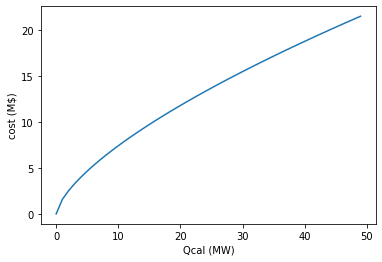

In [22]:
Qcals=np.arange(0,50000,1000)
Ccals=13140*np.power(Qcals,0.67)*Eur2Dollar/1e6
fig,ax=plt.subplots()
ax.plot(Qcals/1e3,Ccals)
ax.set_xlabel("Qcal (MW)")
ax.set_ylabel("cost (M$)")

### choice :  Michalski et al's correlation is more close to our scenerio, which use the external heating source to provide the thermal flux

## Carbonator cost estimation 

In [23]:
Qcarb1=1572912 #W
m_cao=1.010 #kg/s
rho_cao= 3297.63 
v_cao=m_cao/rho_cao #m3/s
Ccarb1_1=16591*math.pow(Qcarb1/1000,0.67)*Eur2Dollar ### based on Michalski et al., Journal of Cleaner Production, 219(2019): 540-551
Ccarb1_2_1=19594*math.pow(Qcarb1/1000,0.5)  ## based on Tesio et al., ECM, 6(2020):100039
Ccarb1_2_2=106200*math.pow(v_cao,0.5)*1e3
Ccarb1_3_2=85.9*math.pow(v_cao,0.5)*1e6*Eur2Dollar ## based on Lena et al., IGGC, 82(2019):244`260
print(f"Ccarb1_1: {Ccarb1_1/1e6} M$")
print(f"Ccarb1_2_1: {Ccarb1_1/1e6} M$, Ccarb1_2_2: {Ccarb1_2_2/1e6} M$")
print(f"Ccarb1_3_2: {Ccarb1_3_2/1e6} M$")

Ccarb1_1: 2.713604406955839 M$
Ccarb1_2_1: 2.713604406955839 M$, Ccarb1_2_2: 1.8585927594348177 M$
Ccarb1_3_2: 1.7739235337272319 M$


### comments:
1. the entrained flow carbonator is cheaper than the fluidized bed carbonator 
2. the cost estimation of the entrained flow carbonator is wrong in Tesio et al's paper, in which the factor of 1e3 may be missing 

## CO2 compressor in calciner side 

### based on Michalski et al., Journal of Cleaner Production, 219(2019): 540-551



cost=compressor + intercooling heat transfer

In [24]:
eff_c=0.87
m_co2=0.3969 # kg/s
compressor_Ti=35 #oC
compressor_Tc=20 #oC
compressor_To_stages=[93.95438673015866, 77.30483442382098, 77.58058758371487, 78.1297166891627,
      79.14305948097035, 80.08382370096854]
compressor_pi_stages= [101325, 207622.32700089482, 425433.3152653984, 871743.9417627172,
      1786267.0193704206, 3660191.613191603]
compressor_po_stages=[207622.32700089482, 425433.3152653984, 871743.9417627172,
      1786267.0193704206, 3660191.613191603, 7499999.999999997]
compressor_power_stages=[21155.289857331296, 20018.569081665843, 19772.868708218593,
      19258.576193110333, 18151.521787245063, 15547.619979204213]
compressor_cooling_energy_stages=[26010.39918493443, 20270.140605142893, 20984.03626507961,
      22665.623143611258, 27608.970860289217, 98564.31906164312]

U=2900 
deltaT=15
Ccs_1=[] 
Cs_HE=[] 

indexs=np.arange(0,6,1)
for i in indexs:
    pi=compressor_pi_stages[i]
    po=compressor_po_stages[i]
    Ti=compressor_Ti
    To=compressor_To_stages[i]
    
    rho_air_in=CP.PropsSI('D', 'T', Ti+273.15, 'P', pi, "REFPROP::air")
    rho_CO2_in=CP.PropsSI('D', 'T', Ti+273.15, 'P', pi, "REFPROP::co2")
    rho_CO2_out=CP.PropsSI('D', 'T', To+273.15, 'P', po, "REFPROP::co2")
    m_air_e=m_co2*rho_air_in/rho_CO2_in
    rho_air_out_e=m_air_e/m_co2*rho_CO2_out
    p_o_air_e=CP.PropsSI("P",'T', To+273.15,"D",rho_air_out_e,"REFPROP::air")
    Cc_1=m_air_e*47.1/(1-eff_c)*p_o_air_e/pi*math.log(p_o_air_e/pi)*Eur2Dollar
    Ccs_1.append(Cc_1)

    Qc=compressor_cooling_energy_stages[i]
    A=Qc/U/deltaT
    C_HE=2546.9*math.pow(A,0.67)*math.pow(po/1e5,0.28)*Eur2Dollar
    Cs_HE.append(C_HE)

#     print(m_air_e,m_air_e,p_o_air_e,Cc_1,A,C_HE)

total_CC=np.sum(Ccs_1)+np.sum(Cs_HE)
print(f"CC_1: {total_CC/1e6} M$")

CC_1: 0.03751834266650559 M$


### based on Tesio et al., ECM, 6(2020):100039

In [25]:
Cc_2=7331*math.pow(np.sum(compressor_power_stages)/1e3,0.7865)
print(f"CC_2: {Cc_2/1e6} M$")

CC_2: 0.30383126378512676 M$


### comments:
1. the compressor cost estimation in Michalski et al.'s study significantly underestimate the compressor cost, which gave a low price of around 160$

2. The cost estimation correlation  in Tesio et al., ECM, 6(2020):100039 cited Carlson et al's studies, which fit the cost with the vendor data. The price has considered the cost of intercooling heat transfer 

### flue gas fan in the carbonator side

In [26]:
Pfan=16521 #W
Cfan1=103193*math.pow(Pfan/445/1000,0.67)*Eur2Dollar ### based on Michalski et al., Journal of Cleaner Production, 219(2019): 540-551
print(f"Cfan1:{Cfan1/1e6} M$")

Cfan1:0.013403412396749232 M$


In [27]:
## if used the CO2 pump based on Michalski et al., Journal of Cleaner Production, 219(2019): 540-551
Cpump1=3531.4*math.pow(Pfan/1000,0.71)*(1+math.pow((1-0.8)/(1-eff_c),3))*Eur2Dollar
print(f"Cpump1:{Cpump1/1e6} M$")

Cpump1:0.141669733689819 M$


### comments:
1. CO2 pump is much expesnive than the normal fan by almost one order of magnitude, it is because
that the the high pressure condition for CO2 pump increase its investment cost 
2. around the abiment condition is our case. So we should use the fan cost to estimate the fan cost 

## Heat transfer network in carbonator side 

In [28]:
import sys
sys.path.append("/home/anoldfriend/Workspace/MyRepo/thermodynamics/CaL/src/CaL-CC-HS")
from pyCaLPlant import Pinch_point_analyzer
CaLRepo = '/home/anoldfriend/Workspace/MyRepo/thermodynamics/CaL'
# print(CaLRepo)
sys.path.append(f"{CaLRepo}/utilities/")
from pyPinch import PyPinch
import json
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
with open("../results.json","r") as fp:
    results=json.load(fp)

pa = Pinch_point_analyzer(results["carb"])
pa.write_pyPinch_data_csv("./pa.csv")
pa_text = pa.write_pyPinch_data_text()
hot_util, cold_util,A = pa.solve(pa_text)
hot_util, cold_util,A

(99.98679402688992, 20944.590000000015, 308.075)

In [30]:
pa.write_pyPinch_data_text()

'Tmin 15 \n       CP    TSUPPLY    TTARGET\n 1.396306 650.000000  20.000000\n 1.719197 650.000000  40.000000\n 2.139066  48.101281 623.714244\n 0.921332  20.000000 634.999739\n26.507541  20.000000  24.136381'


Streams: 
{'type': 'HOT', 'cp': 1.396306, 'ts': 650.0, 'tt': 20.0, 'ss': 642.5, 'st': 12.5}
{'type': 'HOT', 'cp': 1.719197, 'ts': 650.0, 'tt': 40.0, 'ss': 642.5, 'st': 32.5}
{'type': 'COLD', 'cp': 2.139066, 'ts': 48.101281, 'tt': 623.714244, 'ss': 55.601281, 'st': 631.214244}
{'type': 'COLD', 'cp': 0.921332, 'ts': 20.0, 'tt': 634.999739, 'ss': 27.5, 'st': 642.499739}
{'type': 'COLD', 'cp': 26.507541, 'ts': 20.0, 'tt': 24.136381, 'ss': 27.5, 'st': 31.636381}
Tmin = 15.0

Temperature Intervals: 
Interval 0 : {'t1': 642.5, 't2': 642.499739, 'streamNumbers': [0, 1]}
Interval 1 : {'t1': 642.499739, 't2': 631.214244, 'streamNumbers': [0, 1, 3]}
Interval 2 : {'t1': 631.214244, 't2': 55.601281, 'streamNumbers': [0, 1, 2, 3]}
Interval 3 : {'t1': 55.601281, 't2': 32.5, 'streamNumbers': [0, 1, 3]}
Interval 4 : {'t1': 32.5, 't2': 31.636381, 'streamNumbers': [0, 3]}
Interval 5 : {'t1': 31.636381, 't2': 27.5, 'streamNumbers': [0, 3, 4]}
Interval 6 : {'t1': 27.5, 't2': 12.5, 'streamNumbers': [0]}

P

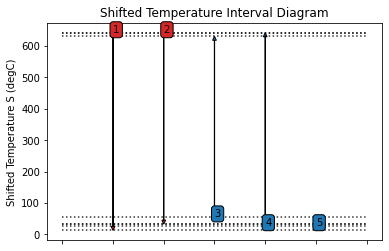

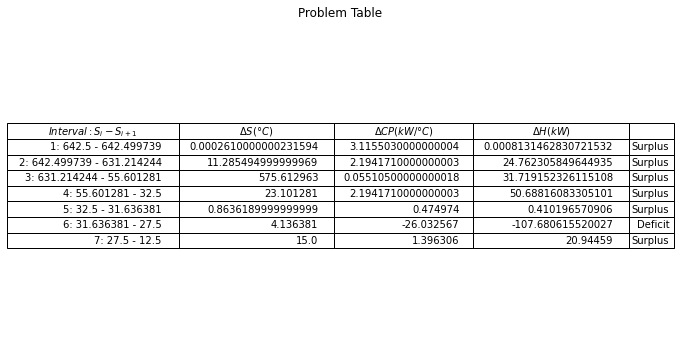

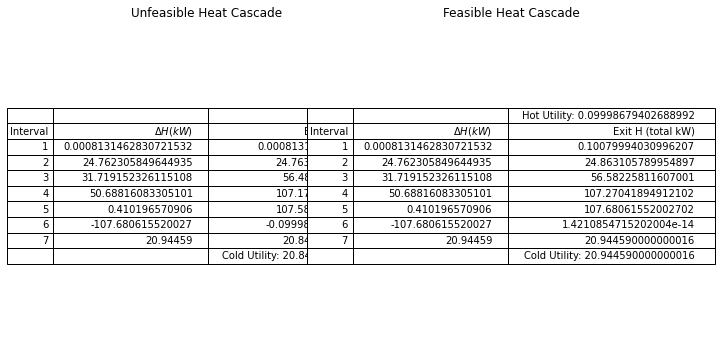

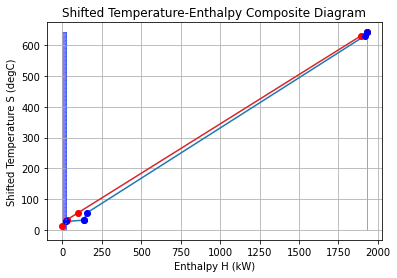

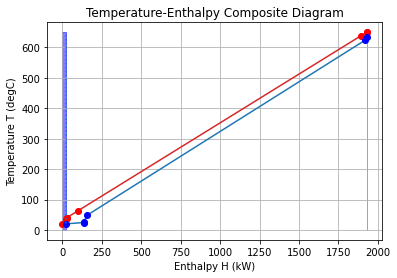

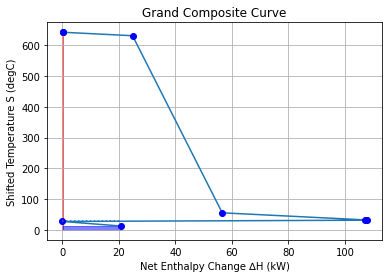

In [31]:
options = {'debug','draw'}
pinch = PyPinch(pa_text,options)
pinch.solve()

In [32]:
HIntervalTable=pinch.EnthaphyIntervalTable
df=pd.DataFrame(HIntervalTable)
df.head(15)

,Hs,Ht,hotshiftedTs,hotshiftedTt,coldshiftedTs,coldshiftedTt,hotStreams,coldStreams,flux,LMTD
0,20.945,26.720,31.636,27.500,27.500,27.711,[0],"[3, 4]",5.775,16.886543
1,26.720,27.926,32.500,31.636,27.711,27.755,[0],"[3, 4]",1.206,19.332102
2,27.926,99.898,55.601,32.500,27.755,30.378,"[0, 1]","[3, 4]",71.972,28.779883
3,99.898,134.401,66.676,55.601,30.378,31.637,"[0, 1]","[3, 4]",34.503,44.952520
4,134.401,135.197,66.931,66.676,31.637,32.501,"[0, 1]",[3],0.796,49.733879
5,135.197,156.480,73.763,66.931,32.501,55.601,"[0, 1]",[3],21.283,40.756313
6,156.480,1893.222,631.214,73.763,55.601,623.090,"[0, 1]","[2, 3]",1736.742,27.842065
7,1893.222,1918.085,639.195,631.214,623.090,631.214,"[0, 1]","[2, 3]",24.863,23.052426
8,1918.085,1928.382,642.500,639.195,631.214,642.390,"[0, 1]",[3],10.297,18.771270


In [33]:
def myRound(a,ndigital=3):
    return round(a,ndigital)

In [34]:
deltaHHots=[]
hotTs=set()
coldTs=set()
deltaHColds=[]
for interval in pinch.temperatureInterval:
    hotH = 0
    coldH = 0
    # Add CP values for the hot and cold streams
    # in a given temperature interval
    for i in interval['streamNumbers']:
        if pinch.streams.streamsData[i]['type'] == 'HOT':
            hotH = hotH + pinch.streams.streamsData[i]['cp']
        else:
            coldH = coldH + pinch.streams.streamsData[i]['cp']
    # Enthalpy = CP * deltaT
    hotH = hotH * (interval['t1'] - interval['t2'])
    deltaHHots.append(hotH)
    hotTs.add(interval['t1'])
    hotTs.add(interval['t2'])
    coldH = coldH * (interval['t1'] - interval['t2'])
    deltaHColds.append(coldH)
    coldTs.add(interval['t1'])
    coldTs.add(interval['t2'])


hotTs=list(hotTs)
hotTs.sort()
coldTs=list(coldTs)
coldTs.sort()
deltaHHots.reverse()
deltaHColds.reverse()

print(f"hotTs: {hotTs}")
print(f"coldTs: {coldTs}")
print(f"deltaHHots: {deltaHHots}")
print(f"deltaHColds: {deltaHColds}")


hotTs: [12.5, 27.5, 31.636381, 32.5, 55.601281, 631.214244, 642.499739, 642.5]
coldTs: [12.5, 27.5, 31.636381, 32.5, 55.601281, 631.214244, 642.499739, 642.5]
deltaHHots: [20.94459, 5.775653608586, 1.2058763914139998, 71.97211025934301, 1793.3239130653892, 35.159993528984906, 0.0008131462830721532]
deltaHColds: [0.0, 113.456269128613, 0.7956798205079999, 21.283949426292, 1761.6047607392743, 10.397687679339972, 0.0]


In [39]:
totalHotH = 0.0
shiftedCompositeDiagram={"hot":{"H":[],"T":[]},"cold":{"H":[],"T":[]}}
shiftedCompositeDiagram['hot']['H'].append(totalHotH)
shiftedCompositeDiagram['hot']['T'].append(hotTs[0])

for i in range(1, len(hotTs)):
    if deltaHHots[i - 1] != 0:
        totalHotH = totalHotH + deltaHHots[i - 1]
        shiftedCompositeDiagram['hot']['H'].append(totalHotH)
        shiftedCompositeDiagram['hot']['T'].append(hotTs[i])

totalColdH = pinch.coldUtility

coldTs2=list()
deltaHColds2=list()
firstTemperature=0
for i in range(0, len(deltaHColds)):
    if deltaHColds[i] > 0:
        firstTemperature=coldTs[i]
        break
coldTs2.append(firstTemperature)
for i in range(0, len(deltaHColds)):
    if deltaHColds[i] > 0:
        coldTs2.append(coldTs[i+1])
        deltaHColds2.append(deltaHColds[i])

shiftedCompositeDiagram['cold']['H'].append(totalColdH)
shiftedCompositeDiagram['cold']['T'].append(coldTs2[0])

for i in range(1, len(coldTs2)):
    totalColdH = totalColdH + deltaHColds2[i-1]
    shiftedCompositeDiagram['cold']['H'].append(totalColdH)
    shiftedCompositeDiagram['cold']['T'].append(coldTs2[i])

print(f"coldTs: {coldTs}")
print(f"deltaHColds: {deltaHColds}")
print(f"coldTs2: {coldTs2}")
print(f"deltaHColds2: {deltaHColds2}")
print(f"shiftedCompositeDiagram: {shiftedCompositeDiagram}")

coldTs: [12.5, 27.5, 31.636381, 32.5, 55.601281, 631.214244, 642.499739, 642.5]
deltaHColds: [0.0, 113.456269128613, 0.7956798205079999, 21.283949426292, 1761.6047607392743, 10.397687679339972, 0.0]
coldTs2: [27.5, 31.636381, 32.5, 55.601281, 631.214244, 642.499739]
deltaHColds2: [113.456269128613, 0.7956798205079999, 21.283949426292, 1761.6047607392743, 10.397687679339972]
shiftedCompositeDiagram: {'hot': {'H': [0.0, 20.94459, 26.720243608586003, 27.926120000000004, 99.89823025934302, 1893.2221433247323, 1928.3821368537172, 1928.3829500000002], 'T': [12.5, 27.5, 31.636381, 32.5, 55.601281, 631.214244, 642.499739, 642.5]}, 'cold': {'H': [20.944590000000016, 134.400859128613, 135.19653894912102, 156.48048837541302, 1918.0852491146873, 1928.4829367940272], 'T': [27.5, 31.636381, 32.5, 55.601281, 631.214244, 642.499739]}}


In [20]:
DTmin=15
compositeDiagram={"hot":{"H":[],"T":[]},"cold":{"H":[],"T":[]}}
for i in range(0,len(shiftedCompositeDiagram["hot"]["H"])):
    compositeDiagram["hot"]["H"].append(shiftedCompositeDiagram["hot"]["H"][i])
    compositeDiagram["hot"]["T"].append(shiftedCompositeDiagram["hot"]["T"][i]+DTmin/2)
for i in range(0,len(shiftedCompositeDiagram["cold"]["H"])):
    compositeDiagram["cold"]["H"].append(shiftedCompositeDiagram["cold"]["H"][i])
    compositeDiagram["cold"]["T"].append(shiftedCompositeDiagram["cold"]["T"][i]-DTmin/2)
print(f"compositeDiagram: {compositeDiagram}")

compositeDiagram: {'hot': {'H': [0.0, 20.94459, 26.720243608586003, 27.926120000000004, 99.89823025934302, 1893.2221433247323, 1928.3821368537172, 1928.3829500000002], 'T': [20.0, 35.0, 39.136381, 40.0, 63.101281, 638.714244, 649.999739, 650.0]}, 'cold': {'H': [20.944590000000016, 134.400859128613, 135.19653894912102, 156.48048837541302, 1918.0852491146873, 1928.4829367940272], 'T': [20.0, 24.136381, 25.0, 48.101281, 623.714244, 634.999739]}}


In [21]:
pinch.temperatureInterval

[{'t1': 642.5, 't2': 642.499739, 'streamNumbers': [0, 1]},
 {'t1': 642.499739, 't2': 631.214244, 'streamNumbers': [0, 1, 3]},
 {'t1': 631.214244, 't2': 55.601281, 'streamNumbers': [0, 1, 2, 3]},
 {'t1': 55.601281, 't2': 32.5, 'streamNumbers': [0, 1, 3]},
 {'t1': 32.5, 't2': 31.636381, 'streamNumbers': [0, 3]},
 {'t1': 31.636381, 't2': 27.5, 'streamNumbers': [0, 3, 4]},
 {'t1': 27.5, 't2': 12.5, 'streamNumbers': [0]}]

In [22]:
DTmin=15
streams={"Hot":[0,1],"Cold":[2,3,4]}

In [23]:
temperatureIntervals=pinch.temperatureInterval
shiftTemperatures=set()
for interval in temperatureIntervals:
    streamNumbers=interval["streamNumbers"]
    HotStreams=list(set(streamNumbers)&set(streams["Hot"]))
    ColdStreams=list(set(streamNumbers)&set(streams["Cold"]))
    if len(HotStreams)>0 and len(ColdStreams)>0:
        shiftTemperatures.add(interval["t1"])
        shiftTemperatures.add(interval["t2"])
shiftTemperatures=list(shiftTemperatures)
shiftTemperatures.sort()
print(f"shiftTemperatures: {shiftTemperatures}")

shiftTemperatures: [27.5, 31.636381, 32.5, 55.601281, 631.214244, 642.499739]


In [24]:
compositeDiagram=shiftedCompositeDiagram
from scipy.interpolate import interp1d
# hotHs=[myRound(H) for H in compositeDiagram['hot']['H']]
# hotTs=[myRound(T) for T in compositeDiagram['hot']['T']]
# coldHs=[myRound(H) for H in compositeDiagram['cold']['H']]
# coldTs=[myRound(T) for T in compositeDiagram['cold']['T']]

hotHs=compositeDiagram['hot']['H']
hotTs=compositeDiagram['hot']['T']
coldHs=compositeDiagram['cold']['H']
coldTs=compositeDiagram['cold']['T']

HotHTcurve=interp1d(hotHs,hotTs,fill_value="extrapolate")
ColdHTCurve=interp1d(coldHs,coldTs,fill_value="extrapolate")
HotTHCurve=interp1d(hotTs,hotHs,fill_value="extrapolate")
ColdTHCurve=interp1d(coldTs,coldHs,fill_value="extrapolate")

Hs=set()

for shiftTemperature in shiftTemperatures:
    HotH=myRound(HotTHCurve(shiftTemperature).item())
    ColdH=myRound(ColdTHCurve(shiftTemperature).item())
    Hs.add(HotH)
    Hs.add(ColdH)
Hs=list(Hs)
Hs.sort()
Hsegments=list()
for i in np.arange(0,len(Hs)-1,1):
    pair=(Hs[i],Hs[i+1])
    Hsegments.append(pair)
print(f"Hs: {Hs}")
print(f"Hsegments: {Hsegments}")



Hs: [20.945, 26.72, 27.926, 99.898, 134.401, 135.197, 156.48, 1893.222, 1918.085, 1928.382, 1928.483]
Hsegments: [(20.945, 26.72), (26.72, 27.926), (27.926, 99.898), (99.898, 134.401), (134.401, 135.197), (135.197, 156.48), (156.48, 1893.222), (1893.222, 1918.085), (1918.085, 1928.382), (1928.382, 1928.483)]


In [25]:
def lessThanOrEqual(a,b,eps=1e-3):
    ret=b-a>0 or abs(a-b)<=eps
    return ret
def greaterThanOrEqual(a,b,eps=1e-3):
    ret=a-b>0 or abs(a-b)<=eps
    return ret 

def isInRange(a,range):
    ret=lessThanOrEqual(range[0],a) and greaterThanOrEqual(range[1],a)
    return ret 

# is range1 the subset of range2
def isSubset(range1,range2):
    ret=greaterThanOrEqual(range1[0],range2[0]) and lessThanOrEqual(range1[1],range2[1])
    return ret 

print(isSubset((1,2),(0.9999,2.00001)))
print(isSubset((1,2),(1.001,1.999)))
print(isSubset((1,2),(1.01,1.999)))
print(isSubset((1,2),(1.001,1.99)))

True
True
False
False


In [26]:
def searchStream(shiftedTRange, streams,type):
    sts=[]
    for i,stream in enumerate(streams):
        # print(stream)
        if (stream['type'] == type):
            ss=stream['ss']
            st=stream['st']
            if ss>st:
                tmp=ss
                ss=st
                st=tmp
            if isSubset(shiftedTRange,(ss,st)):
                sts.append(i)
    return sts

# searchStream((30.742, 31.637),pinch.streams,"COLD")
searchStream((642.39, 642.5),pinch.streams,"COLD")


[3]

In [27]:

EffHSegments=list()
for seg in Hsegments:
    isSig=seg[1]-seg[0]>1e-1
    if isSig:
        EffHSegments.append(seg)
print(f"EffHSegments: {EffHSegments}")

EffHSegments: [(20.945, 26.72), (26.72, 27.926), (27.926, 99.898), (99.898, 134.401), (134.401, 135.197), (135.197, 156.48), (156.48, 1893.222), (1893.222, 1918.085), (1918.085, 1928.382), (1928.382, 1928.483)]


In [28]:

HotTSegments=list()
ColdTSegments=list()
for seg in EffHSegments:
    HotTSeg=(myRound(HotHTcurve(seg[0]).item()),myRound(HotHTcurve(seg[1]).item()))
    HotTSegments.append(HotTSeg)
    ColdTSeg=(myRound(ColdHTCurve(seg[0]).item()),myRound(ColdHTCurve(seg[1]).item()))
    ColdTSegments.append(ColdTSeg)
print(f"Shifted HotTSegments: {HotTSegments}")
print(f"Shifted ColdTSegments: {ColdTSegments}")

Shifted HotTSegments: [(27.5, 31.636), (31.636, 32.5), (32.5, 55.601), (55.601, 66.676), (66.676, 66.931), (66.931, 73.763), (73.763, 631.214), (631.214, 639.195), (639.195, 642.5), (642.5, 642.532)]
Shifted ColdTSegments: [(27.5, 27.711), (27.711, 27.755), (27.755, 30.378), (30.378, 31.637), (31.637, 32.501), (32.501, 55.601), (55.601, 623.09), (623.09, 631.214), (631.214, 642.39), (642.39, 642.5)]


In [29]:
for stream in pinch.streams:
    print(stream)


{'type': 'HOT', 'cp': 1.396306, 'ts': 650.0, 'tt': 20.0, 'ss': 642.5, 'st': 12.5}
{'type': 'HOT', 'cp': 1.719197, 'ts': 650.0, 'tt': 40.0, 'ss': 642.5, 'st': 32.5}
{'type': 'COLD', 'cp': 2.139066, 'ts': 48.101281, 'tt': 623.714244, 'ss': 55.601281, 'st': 631.214244}
{'type': 'COLD', 'cp': 0.921332, 'ts': 20.0, 'tt': 634.999739, 'ss': 27.5, 'st': 642.499739}
{'type': 'COLD', 'cp': 26.507541, 'ts': 20.0, 'tt': 24.136381, 'ss': 27.5, 'st': 31.636381}


In [30]:
HotSegmentStreams=[]
ColdSegmentStreams=[]

for seg in HotTSegments:
    ss=searchStream(seg,pinch.streams,"HOT")
    HotSegmentStreams.append(ss)
for seg in ColdTSegments:
    ss=searchStream(seg,pinch.streams,"COLD")
    ColdSegmentStreams.append(ss)
print(f"HotSegmentStreams: {HotSegmentStreams}")
print(f"ColdSegmentStreams: {ColdSegmentStreams}")


HotSegmentStreams: [[0], [0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], []]
ColdSegmentStreams: [[3, 4], [3, 4], [3, 4], [3, 4], [3], [3], [2, 3], [2, 3], [3], [3]]


In [31]:
streamPropertyTable=[]
materials=["Ca","Gas","Gas","Ca","Water"]
HTCs={"Ca":300,"Water":2500,"Gas":600}
for i,stream in enumerate(pinch.streams):
    record={}
    record["type"]=stream["type"]
    record["MCP"]=stream["cp"]
    record["HTC"]=HTCs[materials[i]]
    streamPropertyTable.append(record)

df_streamProperty=pd.DataFrame(streamPropertyTable)
df_streamProperty.head(5)



,type,MCP,HTC
0,HOT,1.396306,300
1,HOT,1.719197,600
2,COLD,2.139066,600
3,COLD,0.921332,300
4,COLD,26.507541,2500


In [32]:
HIntervalTable=[]
for i,hseg in enumerate(EffHSegments):
    record={}
    record["Hs"]=hseg[0]
    record["Ht"]=hseg[1]
    record["hotshiftedTs"]=HotTSegments[i][1]
    record["hotshiftedTt"]=HotTSegments[i][0]
    record["coldshiftedTs"]=ColdTSegments[i][0]
    record["coldshiftedTt"]=ColdTSegments[i][1]
    record["hotStreams"]=HotSegmentStreams[i]
    record["coldStreams"]=ColdSegmentStreams[i]
    if len(HotSegmentStreams[i])>0 and len(ColdSegmentStreams[i])>0:
        record["flux"]=record["Ht"]-record["Hs"]
        deltaT1=record["hotshiftedTt"]-record["coldshiftedTs"]+DTmin
        deltaT2=record["hotshiftedTs"]-record["coldshiftedTt"]+DTmin
        record["LMTD"]=(deltaT1-deltaT2)/(math.log(deltaT1)-math.log(deltaT2))

        HIntervalTable.append(record)

df=pd.DataFrame(HIntervalTable)
df.head(15)

,Hs,Ht,hotshiftedTs,hotshiftedTt,coldshiftedTs,coldshiftedTt,hotStreams,coldStreams,flux,LMTD
0,20.945,26.720,31.636,27.500,27.500,27.711,[0],"[3, 4]",5.775,16.886543
1,26.720,27.926,32.500,31.636,27.711,27.755,[0],"[3, 4]",1.206,19.332102
2,27.926,99.898,55.601,32.500,27.755,30.378,"[0, 1]","[3, 4]",71.972,28.779883
3,99.898,134.401,66.676,55.601,30.378,31.637,"[0, 1]","[3, 4]",34.503,44.952520
4,134.401,135.197,66.931,66.676,31.637,32.501,"[0, 1]",[3],0.796,49.733879
5,135.197,156.480,73.763,66.931,32.501,55.601,"[0, 1]",[3],21.283,40.756313
6,156.480,1893.222,631.214,73.763,55.601,623.090,"[0, 1]","[2, 3]",1736.742,27.842065
7,1893.222,1918.085,639.195,631.214,623.090,631.214,"[0, 1]","[2, 3]",24.863,23.052426
8,1918.085,1928.382,642.500,639.195,631.214,642.390,"[0, 1]",[3],10.297,18.771270


In [33]:
for record in HIntervalTable:
    hotStreams=record["hotStreams"]
    hotHTCs=[streamPropertyTable[i]["HTC"] for i in hotStreams]
    hotMCPs=[streamPropertyTable[i]["MCP"] for i in hotStreams]
    coldStreams=record["coldStreams"]
    coldHTCs=[streamPropertyTable[i]["HTC"] for i in coldStreams]
    coldMCPs=[streamPropertyTable[i]["MCP"] for i in coldStreams]
    record["hotQi"]=[myRound(cp*(record["hotshiftedTs"]-record["hotshiftedTt"])) for cp in hotMCPs]
    record["coldQi"]=[myRound(cp*(record["coldshiftedTt"]-record["coldshiftedTs"])) for cp in coldMCPs]
    hotHXA=[]
    coldHXA=[]
    for i,Qi in enumerate(record["hotQi"]):
        hotHXA.append(myRound(Qi/record["LMTD"]/hotHTCs[i]*1000))
    for i,Qi in enumerate(record["coldQi"]):
        coldHXA.append(myRound(Qi/record["LMTD"]/coldHTCs[i]*1000))
    record["hotHXA"]=hotHXA
    record["coldHXA"]=coldHXA


df=pd.DataFrame(HIntervalTable)
df.head(15)


,Hs,Ht,hotshiftedTs,hotshiftedTt,coldshiftedTs,coldshiftedTt,hotStreams,coldStreams,flux,LMTD,hotQi,coldQi,hotHXA,coldHXA
0,20.945,26.720,31.636,27.500,27.500,27.711,[0],"[3, 4]",5.775,16.886543,[5.775],"[0.194, 5.593]",[1.14],"[0.038, 0.132]"
1,26.720,27.926,32.500,31.636,27.711,27.755,[0],"[3, 4]",1.206,19.332102,[1.206],"[0.041, 1.166]",[0.208],"[0.007, 0.024]"
2,27.926,99.898,55.601,32.500,27.755,30.378,"[0, 1]","[3, 4]",71.972,28.779883,"[32.256, 39.715]","[2.417, 69.529]","[3.736, 2.3]","[0.28, 0.966]"
3,99.898,134.401,66.676,55.601,30.378,31.637,"[0, 1]","[3, 4]",34.503,44.952520,"[15.464, 19.04]","[1.16, 33.373]","[1.147, 0.706]","[0.086, 0.297]"
4,134.401,135.197,66.931,66.676,31.637,32.501,"[0, 1]",[3],0.796,49.733879,"[0.356, 0.438]",[0.796],"[0.024, 0.015]",[0.053]
5,135.197,156.480,73.763,66.931,32.501,55.601,"[0, 1]",[3],21.283,40.756313,"[9.54, 11.746]",[21.283],"[0.78, 0.48]",[1.741]
6,156.480,1893.222,631.214,73.763,55.601,623.090,"[0, 1]","[2, 3]",1736.742,27.842065,"[778.372, 958.368]","[1213.896, 522.846]","[93.189, 57.369]","[72.666, 62.597]"
7,1893.222,1918.085,639.195,631.214,623.090,631.214,"[0, 1]","[2, 3]",24.863,23.052426,"[11.144, 13.721]","[17.378, 7.485]","[1.611, 0.992]","[1.256, 1.082]"
8,1918.085,1928.382,642.500,639.195,631.214,642.390,"[0, 1]",[3],10.297,18.771270,"[4.615, 5.682]",[10.297],"[0.82, 0.504]",[1.829]


In [34]:
totalHXA=0
for record in HIntervalTable:
    for HXA in record["hotHXA"]:
        totalHXA=totalHXA+HXA
    for HXA in record["coldHXA"]:
        totalHXA=totalHXA+HXA
print(f"totalHXA:{totalHXA}")

totalHXA:308.075


### based on Fluid-Fluid HEX cost estimation (Tesio et al., Energy Conversion and Management: X, 6(2020), 100039)

In [35]:
IC_HX=3197*math.pow(totalHXA,0.67)
print(f"IC_HX: {IC_HX/1e6 }M$")

IC_HX: 0.148642315694627M$


### based on Fluid-Solid HEX cost estimation (Tesio et al., Energy Conversion and Management: X, 6(2020), 100039)

In [36]:
U=250
IC_HX2=18.48*math.pow(U*totalHXA,0.67)
print(f"IC_HX: {IC_HX2/1e6 }M$")

IC_HX: 0.034731344755148656M$


### comments:
1. It is difficult to figure out the HX area distribution over the two kinds of HX, that is Fluid-fluid HX and fluid-solid HX, and the HTC of the fluid-fluid HX is difficult to be determined due to the varying fluid type, including the flue gas and water
2. and we found the cost estimation based on the Fluid-fluid HX is more conservative compared to the solid-fluid HX
3. Therefore, we recommned to estimate the HX based on Fluid-Fluid HEX cost estimation (Tesio et al., Energy Conversion and Management: X, 6(2020), 100039)